# ROC Curves

The ROC curve plots the true positive rate against the false positive rate. Instead of a confusion matrix for each classifier, we opted for ROC curves as it provides a convenient method to compare the performance of the classifiers chosen.

Since ROC curves are typically used in binary classification, it was extended for use in our multi-class problem by:
1. Binarizing the target. 
2. Using micro-average for each classifier. Since we have an imbalanced (skewed) data set, the  micro-average will aggregate the contributions of all classes to compute the average. 
3. One-versus-the-rest strategy is used. The decision score from each classifier and  the class whose classifier outputs the highest score. 


In [1]:
print("ROC")

ROC


In [2]:
import numpy as np
import pandas as pd

# Import training data 
train = pd.read_csv('../final_data/F40.csv')

n=40 #numbr of shortlisted features

In [3]:
X = train.iloc[:,0:n].copy()
y = train.iloc[:,n].copy()

In [4]:
from sklearn.preprocessing import scale
X = scale(X)  #To ensure all features are in the same scale

In [15]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Import  classifiers
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import numpy as np
import matplotlib.pyplot as plt


# label_binarize to make multi-label like settings
from sklearn.preprocessing import label_binarize

# OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split


from scipy import interp
from itertools import cycle
from inspect import signature


In [16]:
random_state = 1234

In [17]:
# Instantiate the classfiers and make a list.

classifiers = [GaussianNB(),              
               KNeighborsClassifier(n_neighbors=8,weights='distance',p=2),                
               DecisionTreeClassifier(random_state=random_state),                
               RandomForestClassifier(class_weight = 'balanced',random_state=random_state),
               svm.SVC(probability=True,random_state=random_state,verbose=10),
               LogisticRegressionCV(class_weight='balanced', solver = 'lbfgs',max_iter=1000, verbose =10,
                                    multi_class = 'multinomial',random_state=random_state) 
]


In [18]:
# Use label_binarize to be multi-label like settings
y = label_binarize(y, classes=[1, 2, 3,4,5,6,7,8])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.15,
                                                    random_state=0,
                                                    stratify=y)


classifier: GaussianNB
classifier: KNeighborsClassifier
classifier: DecisionTreeClassifier
classifier: RandomForestClassifier
classifier: SVC
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]classifier: LogisticRegressionCV


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3

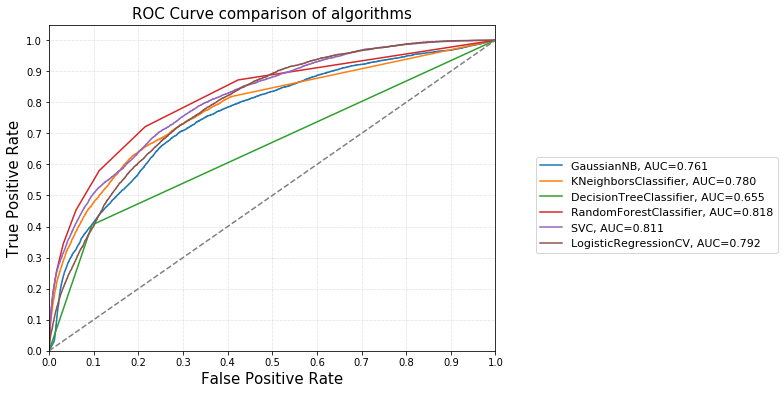

CPU times: user 1h 34min 1s, sys: 1min 7s, total: 1h 35min 8s
Wall time: 1h 33min 15s


In [19]:
%%time

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifier', 'fpr_micro','tpr_micro','auc_micro'])


#for each classifier
for cls in classifiers:
    print("classifier:",cls.__class__.__name__)

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(cls)
    #y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()

    #precision and recall curve
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], probas_[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], probas_[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),probas_.ravel())
    average_precision["micro"] = average_precision_score(y_test, probas_,average="micro")
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probas_[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probas_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    result_table = result_table.append({'classifier':cls.__class__.__name__,
                                    'fpr_micro':fpr["micro"],'tpr_micro':tpr["micro"],'auc_micro':roc_auc["micro"]}, ignore_index=True)

#plot the curves
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr_micro'],result_table.loc[i]['tpr_micro'], 
             label="{}, AUC={:.3f}".format(result_table.loc[i]['classifier'], 
                                           result_table.loc[i]['auc_micro']))

    #plot the random guess line    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve comparison of algorithms', fontsize=15)
plt.legend(prop={'size':11}, loc=(1.09,.3) )
plt.grid(True, linestyle=':', linewidth=0.5)

plt.savefig('ROC comparison.png', bbox_inches='tight')
plt.show()

#REF: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [20]:
print("DONE")

DONE


In [ ]:
#7 at 5 pm
#8 at 5:25 